# Importamos directorios

In [2]:
!pip install mne 
import mne
import pandas as pd
import numpy as np

In [3]:
# Cargar señal
raw = mne.io.read_raw_brainvision("sub-S001_ses-01_task-MatrixCalibration_run-01_eeg.vhdr", preload=True)

# Filtrar 1–50 Hz (típico de BCI)
raw.filter(1, 40)

# Eliminar interferencia de 60 Hz
raw.notch_filter(60)

# ---- LEER EL events.tsv ----
events_tsv = pd.read_csv(
    "sub-S001_ses-01_task-MatrixCalibration_run-01_events.tsv",
    sep="\t"
)

# Mostrar los canales
raw.plot()

raw = raw.set_eeg_reference("average")

Extracting parameters from sub-S001_ses-01_task-MatrixCalibration_run-01_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 276082  =      0.000 ...   920.273 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 991 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

FileNotFoundError: [Errno 2] No such file or directory: 'sub-S001_ses-01_task-MatrixCalibration_run-01_events.tsv'

# Viendo todos los estimulos

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15'), np.str_('Stimulus/S 16'), np.str_('Stimulus/S 17'), np.str_('Stimulus/S 18'), np.str_('Stimulus/S 19'), np.str_('Stimulus/S 20'), np.str_('Stimulus/S 21'), np.str_('Stimulus/S 22'), np.str_('Stimulus/S 23'), np.str_('Stimulus/S 24'), np.str_('Stimulus/S 25'), np.str_('Stimulus/S 26'), np.str_('Stimulus/S 27'), np.str_('Stimulus/S 28'), np.str_('Stimulus/S 29'), np.str_('Stimulus/S 30')]
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1000 matching events found
Setting baseline interval to [-0.2

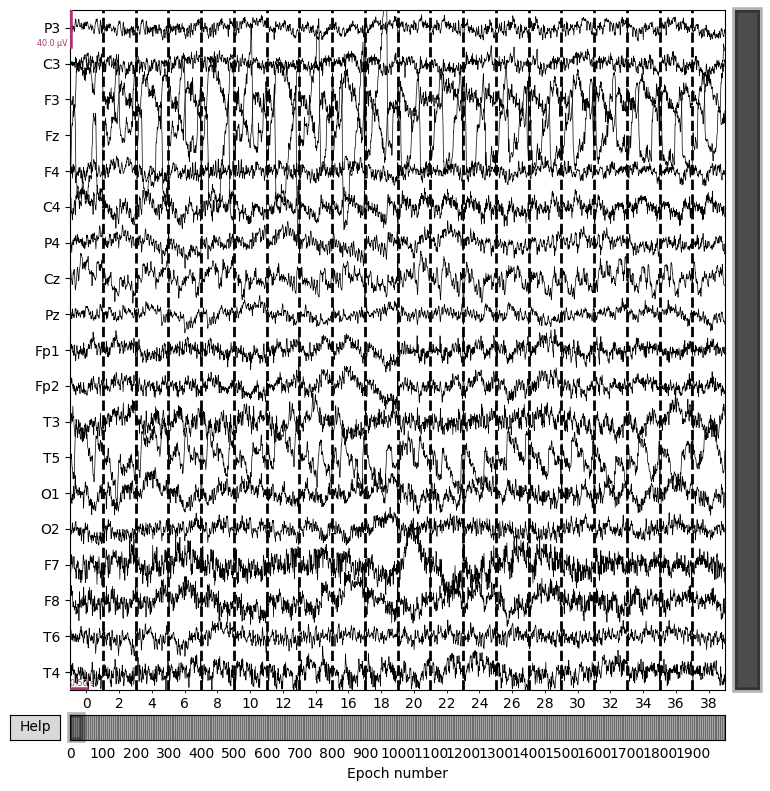

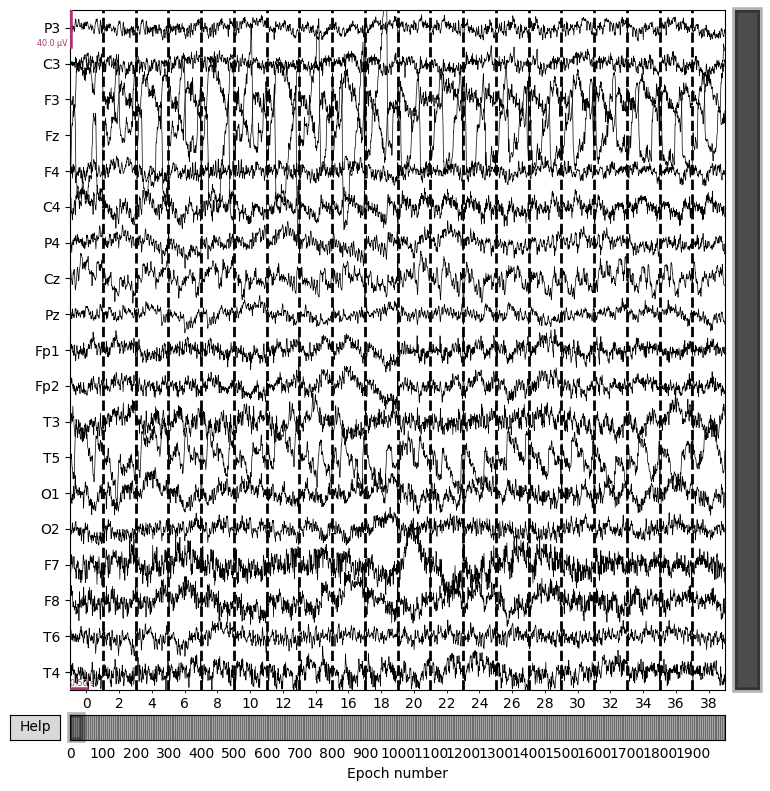

In [ ]:
# Extraer eventos desde las anotaciones
events, event_id = mne.events_from_annotations(raw)

epochs = mne.Epochs(
    raw, 
    events, 
    event_id, 
    tmin=-0.2, 
    tmax=0.8, 
    baseline=(None, 0),
    event_repeated="drop"   # elimina duplicados
)

epochs.plot()

# epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.8, baseline=(None, 0))
# epochs['target'].average().plot()

# Visualizando target/non target 

Not setting metadata
1000 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1000 events and 301 original time points ...
0 bad epochs dropped


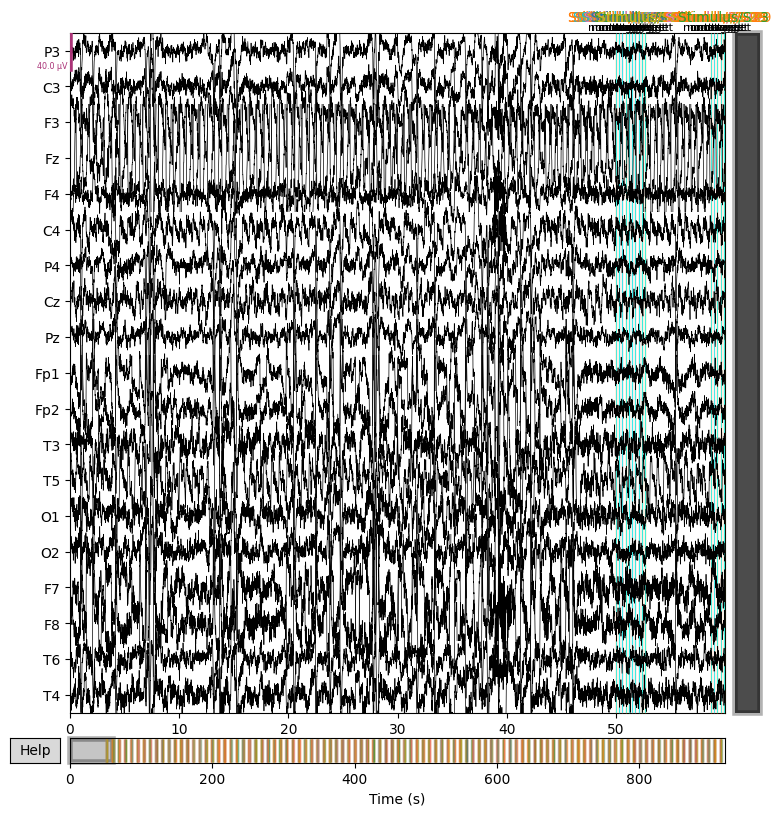

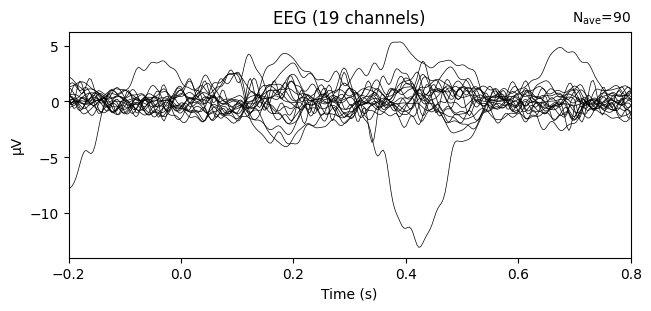

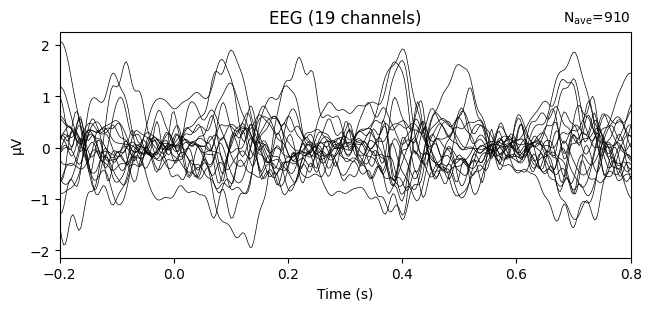

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


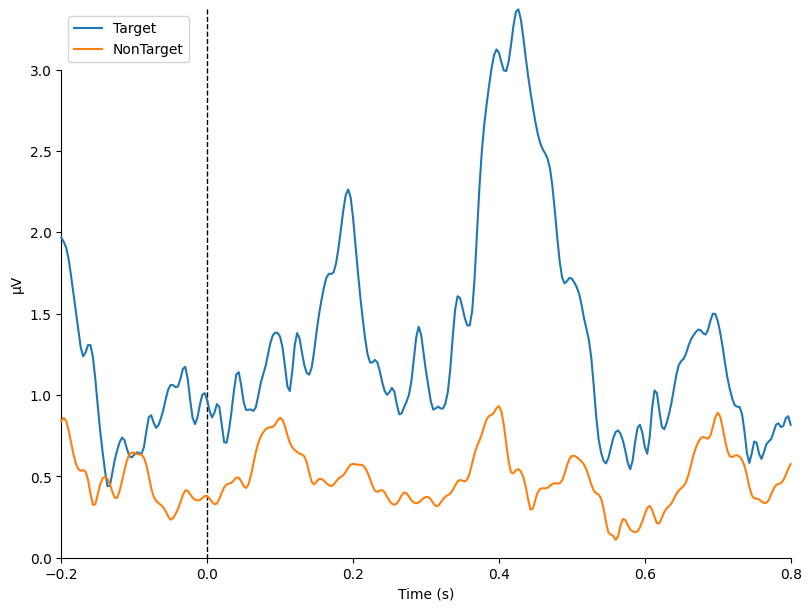

[<Figure size 800x600 with 1 Axes>]

In [ ]:
# Filtrar solo filas con target o nontarget
df = events_tsv[events_tsv["trial_type"].isin(["target", "nontarget"])]

# Crear diccionario de IDs
event_id = {"target": 1, "nontarget": 2}

# Construir matriz de eventos (n_events x 3)
# columna 1: sample (entero)
# columna 2: 0 (requerido por MNE)
# columna 3: event_id basado en target/nontarget

events = []

for _, row in df.iterrows():
    events.append([
        int(row["sample"]),
        0,
        event_id[row["trial_type"]]
    ])

events = np.array(events)

epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin=-0.2,
    tmax=0.8,
    baseline=(None, 0),
    preload=True
)

#%matplotlib qt
raw.plot(events=events, event_id=event_id, duration=60)
#%matplotlib inline

evoked_target = epochs["target"].average()
evoked_nontarget = epochs["nontarget"].average()

evoked_target.plot()
evoked_nontarget.plot()

mne.viz.plot_compare_evokeds(
    {"Target": evoked_target, "NonTarget": evoked_nontarget}
)


# Parámetros del data set

In [ ]:
# Datos básicos del RAW
print("sfreq:", raw.info['sfreq'])
print("first_samp:", raw.first_samp)
print("n_times:", raw.n_times)
print("duracion (s):", raw.n_times / raw.info['sfreq'])

# Eventos que tú construiste
print("events shape:", events.shape)
print("events dtype:", events.dtype)
print("codigos:", np.unique(events[:,2]))
print("min/max sample:", events[:,0].min(), events[:,0].max())

# Tiempo en segundos del primer evento
t0 = (events[0,0] - raw.first_samp) / raw.info['sfreq']
print("primer evento ocurre en t=", t0, "segundos")



sfreq: 300.0
first_samp: 0
n_times: 276083
duracion (s): 920.2766666666666
events shape: (1000, 3)
events dtype: int64
codigos: [1 2]
min/max sample: 14994 274655
primer evento ocurre en t= 49.98 segundos
